<a href="https://colab.research.google.com/github/aimbsg/EVA4_S10/blob/master/EVA4_S10_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure  to Add CutOut to your code. It should come from your transformations (albumentations)

Implement LR Finder (for SGD, not for ADAM). Use this repo: https://github.com/davidtvs/pytorch-lr-finder (Links to an external site.)

Move LR Finder code to your modules

Implement ReduceLROnPlatea: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau (Links to an external site.)

Find best LR to train your model

Use SGD with Momentum

Train for 50 Epochs. 

Show Training and Test Accuracy curves

Target 88% Accuracy.

Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.

In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-blkq3rj9
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-blkq3rj9
     |████████████████████████████████| 634kB 40.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=9fbce4a949ef7a59206ba97e1a0913d42070dedd2a00cee2ed56727ce77b6bb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-v80qonkl/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=117f13c832d58ea6647886c679abffe13a233975ee94dce3d9b5c2aa78ea8c20
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
my_path = '/content/gdrive/My Drive/EVA4S10_CIFAR10'
sys.path.append(my_path)

In [4]:
%cd '/content/gdrive/My Drive/EVA4S10_CIFAR10/'
!pwd

/content/gdrive/My Drive/EVA4S10_CIFAR10
/content/gdrive/My Drive/EVA4S10_CIFAR10


In [0]:
%matplotlib inline
import torch
import data_loader as train_test_loader
import visualize_images as show_images
import backbone as model
import train_test
import model_evaluator as evaluate
from transforms_albumentation import AlbumentationTransforms
from gradcam import GradCAM,visualize_cam

In [0]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1) 
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [7]:
classes, trainloader, testloader = train_test_loader.load(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


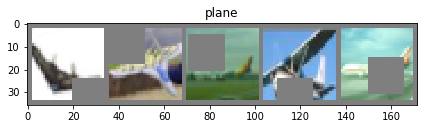

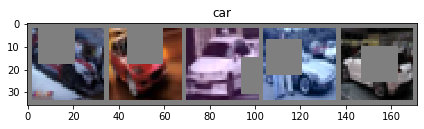

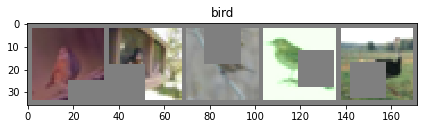

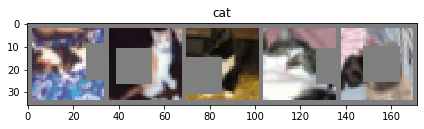

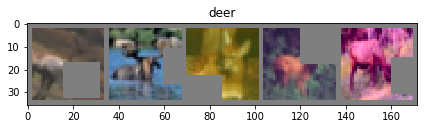

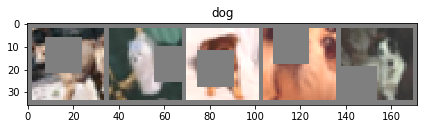

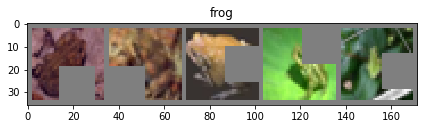

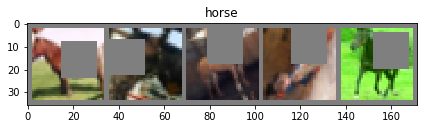

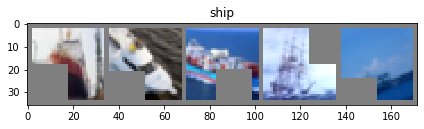

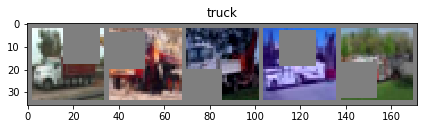

In [0]:
show_images.show_train_data(trainloader, classes)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

LR Finder

https://github.com/davidtvs/pytorch-lr-finder/blob/master/torch_lr_finder/lr_finder.py

In [0]:
#@title LR finder package installer
!pip install torch-lr-finder -v --global-option="amp"

In [0]:
import torch_lr_finder as lr

In [0]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=1e-05,momentum=0.9 ,weight_decay = 0.0001)
lr_finder = lr.LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=500 ,step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


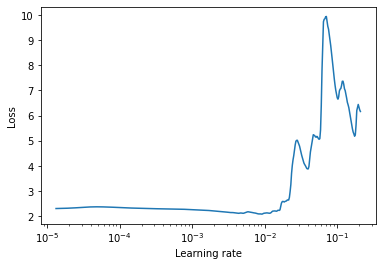

In [0]:
lr_finder.plot()

In [0]:
ideal_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
ideal_lr

0.009120108393559095

In [0]:
lr_finder.reset()

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9,weight_decay=0.0001, nesterov=False)
scheduler = ReduceLROnPlateau(optimizer, patience = 3)

# from torch.optim.lr_scheduler import StepLR , MultiStepLR
# optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9,weight_decay=0.0005)
# scheduler = StepLR(optimizer, step_size=12, gamma=0.1)

In [11]:
train_loss = [] 
train_acc = []
test_loss = []
test_acc = []
epochs = 50
best_acc = 85 # save the model only if the accuracy crosses 85% as we already achieved 88% in previous assignment without LR finder

for epoch in range(epochs):
     print("Epoch:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_test.train(model, device, trainloader, optimizer, criterion, epoch)     
    #  scheduler.step()
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     train_loss , train_acc = train_test.train_metrics_accumulator(model, device, criterion, trainloader)
     scheduler.step(test_loss[-1])
    
     if(test_acc[-1]>best_acc):
       print("...BEST MODEL...")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/EVA4S10_CIFAR10/bestmodel_50epochs.pt")
       print("Save success...")

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 1 LR: 0.009120108393559095


Loss=1.6979713439941406 Batch_id=390 Accuracy=30.84: 100%|██████████| 391/391 [00:57<00:00,  6.77it/s]



Test set: Average loss: 0.0117, Accuracy: 4505/10000 (45.05%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 2 LR: 0.009120108393559095


Loss=1.701568841934204 Batch_id=390 Accuracy=44.75: 100%|██████████| 391/391 [00:59<00:00,  6.61it/s]



Test set: Average loss: 0.0099, Accuracy: 5592/10000 (55.92%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 3 LR: 0.009120108393559095


Loss=1.284343957901001 Batch_id=390 Accuracy=50.98: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0086, Accuracy: 6235/10000 (62.35%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 4 LR: 0.009120108393559095


Loss=0.9819814562797546 Batch_id=390 Accuracy=56.27: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0078, Accuracy: 6576/10000 (65.76%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 5 LR: 0.009120108393559095


Loss=1.4640308618545532 Batch_id=390 Accuracy=59.44: 100%|██████████| 391/391 [00:59<00:00,  6.59it/s]



Test set: Average loss: 0.0079, Accuracy: 6610/10000 (66.10%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 6 LR: 0.009120108393559095


Loss=0.9801748991012573 Batch_id=390 Accuracy=62.65: 100%|██████████| 391/391 [00:59<00:00,  6.59it/s]



Test set: Average loss: 0.0080, Accuracy: 6875/10000 (68.75%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 7 LR: 0.009120108393559095


Loss=1.0729793310165405 Batch_id=390 Accuracy=64.62: 100%|██████████| 391/391 [00:59<00:00,  6.53it/s]



Test set: Average loss: 0.0066, Accuracy: 7126/10000 (71.26%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 8 LR: 0.009120108393559095


Loss=0.9252451062202454 Batch_id=390 Accuracy=66.02: 100%|██████████| 391/391 [00:59<00:00,  6.60it/s]



Test set: Average loss: 0.0068, Accuracy: 7150/10000 (71.50%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 9 LR: 0.009120108393559095


Loss=0.9611090421676636 Batch_id=390 Accuracy=67.47: 100%|██████████| 391/391 [00:59<00:00,  6.61it/s]



Test set: Average loss: 0.0061, Accuracy: 7413/10000 (74.13%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 10 LR: 0.009120108393559095


Loss=0.8010448217391968 Batch_id=390 Accuracy=68.96: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]



Test set: Average loss: 0.0053, Accuracy: 7719/10000 (77.19%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 11 LR: 0.009120108393559095


Loss=0.7763941287994385 Batch_id=390 Accuracy=69.61: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]



Test set: Average loss: 0.0059, Accuracy: 7508/10000 (75.08%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 12 LR: 0.009120108393559095


Loss=0.9059357643127441 Batch_id=390 Accuracy=70.34: 100%|██████████| 391/391 [00:58<00:00,  6.64it/s]



Test set: Average loss: 0.0050, Accuracy: 7847/10000 (78.47%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 13 LR: 0.009120108393559095


Loss=0.8418265581130981 Batch_id=390 Accuracy=71.74: 100%|██████████| 391/391 [00:58<00:00,  6.64it/s]



Test set: Average loss: 0.0050, Accuracy: 7838/10000 (78.38%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 14 LR: 0.009120108393559095


Loss=0.7894745469093323 Batch_id=390 Accuracy=72.14: 100%|██████████| 391/391 [00:59<00:00,  6.60it/s]



Test set: Average loss: 0.0051, Accuracy: 7903/10000 (79.03%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 15 LR: 0.009120108393559095


Loss=0.7010317444801331 Batch_id=390 Accuracy=72.73: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 0.0047, Accuracy: 7965/10000 (79.65%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 16 LR: 0.009120108393559095


Loss=0.7029109597206116 Batch_id=390 Accuracy=73.56: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0051, Accuracy: 7837/10000 (78.37%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 17 LR: 0.009120108393559095


Loss=0.6517860293388367 Batch_id=390 Accuracy=74.26: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0045, Accuracy: 8116/10000 (81.16%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 18 LR: 0.009120108393559095


Loss=0.8828343152999878 Batch_id=390 Accuracy=74.82: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0045, Accuracy: 8057/10000 (80.57%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 19 LR: 0.009120108393559095


Loss=0.630820631980896 Batch_id=390 Accuracy=75.25: 100%|██████████| 391/391 [00:59<00:00,  6.55it/s]



Test set: Average loss: 0.0043, Accuracy: 8158/10000 (81.58%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 20 LR: 0.009120108393559095


Loss=0.5964604020118713 Batch_id=390 Accuracy=75.69: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0044, Accuracy: 8177/10000 (81.77%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 21 LR: 0.009120108393559095


Loss=0.7151039242744446 Batch_id=390 Accuracy=75.99: 100%|██████████| 391/391 [00:59<00:00,  6.56it/s]



Test set: Average loss: 0.0038, Accuracy: 8352/10000 (83.52%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 22 LR: 0.009120108393559095


Loss=0.6387998461723328 Batch_id=390 Accuracy=76.52: 100%|██████████| 391/391 [00:59<00:00,  6.56it/s]



Test set: Average loss: 0.0043, Accuracy: 8234/10000 (82.34%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 23 LR: 0.009120108393559095


Loss=0.6297863721847534 Batch_id=390 Accuracy=77.01: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0038, Accuracy: 8379/10000 (83.79%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 24 LR: 0.009120108393559095


Loss=0.631105899810791 Batch_id=390 Accuracy=77.49: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 0.0045, Accuracy: 8167/10000 (81.67%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 25 LR: 0.009120108393559095


Loss=0.7105317115783691 Batch_id=390 Accuracy=77.75: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 0.0038, Accuracy: 8385/10000 (83.85%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 26 LR: 0.009120108393559095


Loss=0.6486462950706482 Batch_id=390 Accuracy=77.89: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0038, Accuracy: 8406/10000 (84.06%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 27 LR: 0.009120108393559095


Loss=0.6144945621490479 Batch_id=390 Accuracy=78.28: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0034, Accuracy: 8534/10000 (85.34%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 28 LR: 0.009120108393559095


Loss=0.4877152442932129 Batch_id=390 Accuracy=79.00: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 0.0033, Accuracy: 8574/10000 (85.74%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 29 LR: 0.009120108393559095


Loss=0.4661920666694641 Batch_id=390 Accuracy=78.79: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 0.0038, Accuracy: 8401/10000 (84.01%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 30 LR: 0.009120108393559095


Loss=0.6570422649383545 Batch_id=390 Accuracy=79.30: 100%|██████████| 391/391 [00:59<00:00,  6.56it/s]



Test set: Average loss: 0.0034, Accuracy: 8543/10000 (85.43%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 31 LR: 0.009120108393559095


Loss=0.4129409193992615 Batch_id=390 Accuracy=79.52: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 0.0036, Accuracy: 8536/10000 (85.36%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 32 LR: 0.009120108393559095


Loss=0.48678532242774963 Batch_id=390 Accuracy=79.87: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 0.0033, Accuracy: 8542/10000 (85.42%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 33 LR: 0.009120108393559095


Loss=0.5463545322418213 Batch_id=390 Accuracy=80.63: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0036, Accuracy: 8491/10000 (84.91%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 34 LR: 0.009120108393559095


Loss=0.47639304399490356 Batch_id=390 Accuracy=80.45: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0031, Accuracy: 8705/10000 (87.05%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 35 LR: 0.009120108393559095


Loss=0.541251540184021 Batch_id=390 Accuracy=81.06: 100%|██████████| 391/391 [00:59<00:00,  6.56it/s]



Test set: Average loss: 0.0033, Accuracy: 8582/10000 (85.82%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 36 LR: 0.009120108393559095


Loss=0.6077497601509094 Batch_id=390 Accuracy=81.12: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0032, Accuracy: 8649/10000 (86.49%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 37 LR: 0.009120108393559095


Loss=0.5521738529205322 Batch_id=390 Accuracy=81.29: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 0.0032, Accuracy: 8635/10000 (86.35%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 38 LR: 0.009120108393559095


Loss=0.5490642786026001 Batch_id=390 Accuracy=81.55: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 0.0032, Accuracy: 8658/10000 (86.58%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 39 LR: 0.0009120108393559095


Loss=0.5510752201080322 Batch_id=390 Accuracy=83.54: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0027, Accuracy: 8857/10000 (88.57%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 40 LR: 0.0009120108393559095


Loss=0.5921268463134766 Batch_id=390 Accuracy=83.92: 100%|██████████| 391/391 [00:59<00:00,  6.54it/s]



Test set: Average loss: 0.0027, Accuracy: 8838/10000 (88.38%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 41 LR: 0.0009120108393559095


Loss=0.505922794342041 Batch_id=390 Accuracy=84.43: 100%|██████████| 391/391 [00:59<00:00,  6.62it/s]



Test set: Average loss: 0.0026, Accuracy: 8881/10000 (88.81%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 42 LR: 0.0009120108393559095


Loss=0.4080592095851898 Batch_id=390 Accuracy=84.47: 100%|██████████| 391/391 [00:58<00:00,  6.64it/s]



Test set: Average loss: 0.0026, Accuracy: 8904/10000 (89.04%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 43 LR: 0.0009120108393559095


Loss=0.39966681599617004 Batch_id=390 Accuracy=84.61: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]



Test set: Average loss: 0.0026, Accuracy: 8881/10000 (88.81%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 44 LR: 0.0009120108393559095


Loss=0.29535427689552307 Batch_id=390 Accuracy=84.67: 100%|██████████| 391/391 [00:58<00:00,  6.64it/s]



Test set: Average loss: 0.0026, Accuracy: 8888/10000 (88.88%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 45 LR: 0.0009120108393559095


Loss=0.5216056704521179 Batch_id=390 Accuracy=84.47: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]



Test set: Average loss: 0.0026, Accuracy: 8902/10000 (89.02%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 46 LR: 0.0009120108393559095


Loss=0.2919389307498932 Batch_id=390 Accuracy=84.63: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]



Test set: Average loss: 0.0026, Accuracy: 8917/10000 (89.17%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 47 LR: 0.0009120108393559095


Loss=0.6490464210510254 Batch_id=390 Accuracy=84.87: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]



Test set: Average loss: 0.0026, Accuracy: 8899/10000 (88.99%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 48 LR: 9.120108393559096e-05


Loss=0.3526955544948578 Batch_id=390 Accuracy=85.16: 100%|██████████| 391/391 [00:59<00:00,  6.55it/s]



Test set: Average loss: 0.0025, Accuracy: 8925/10000 (89.25%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 49 LR: 9.120108393559096e-05


Loss=0.4280540347099304 Batch_id=390 Accuracy=85.25: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]



Test set: Average loss: 0.0025, Accuracy: 8951/10000 (89.51%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 50 LR: 9.120108393559096e-05


Loss=0.2584438621997833 Batch_id=390 Accuracy=85.07: 100%|██████████| 391/391 [00:59<00:00,  6.56it/s]



Test set: Average loss: 0.0025, Accuracy: 8936/10000 (89.36%)



In [12]:
evaluate.val_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 88.99 %


In [13]:
evaluate.class_accuracy(model, device, classes, testloader)

Accuracy of plane : 90 %
Accuracy of   car : 95 %
Accuracy of  bird : 86 %
Accuracy of   cat : 75 %
Accuracy of  deer : 89 %
Accuracy of   dog : 83 %
Accuracy of  frog : 91 %
Accuracy of horse : 92 %
Accuracy of  ship : 94 %
Accuracy of truck : 95 %


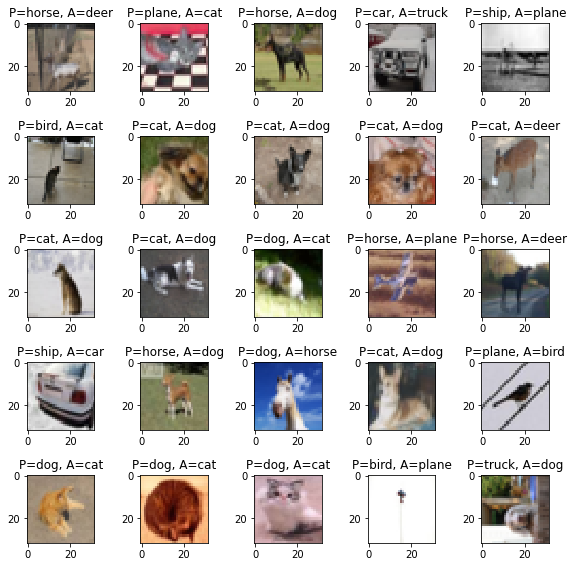

In [14]:
evaluate.view_misclassified_images(model, device, testloader, classes)

Text(0.5, 1.0, 'Test Accuracy')

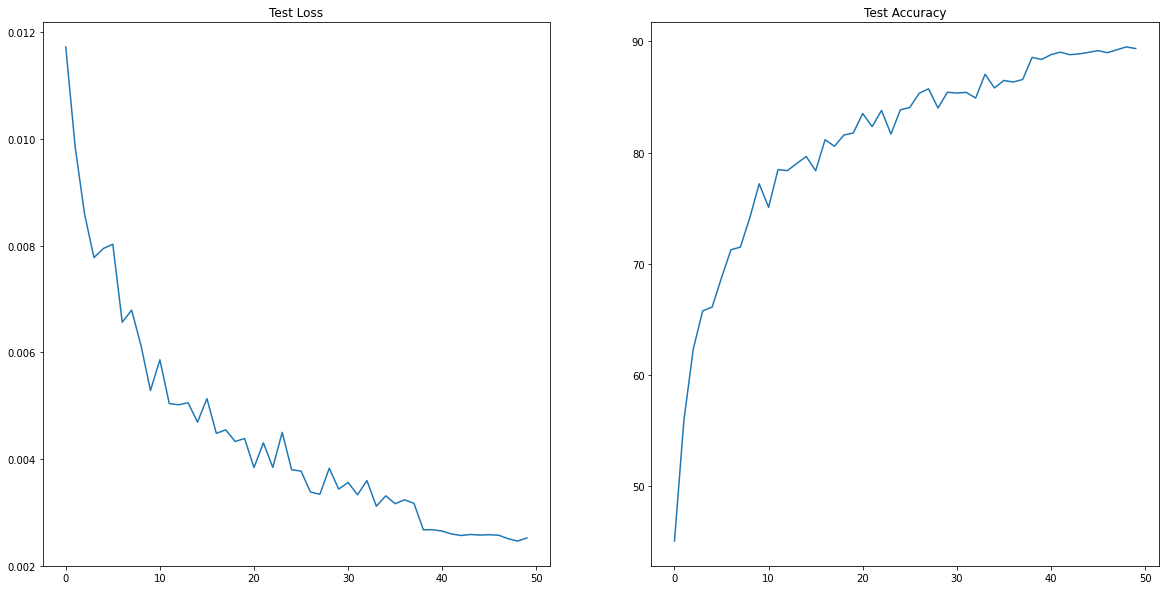

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(test_loss)
axs[0].set_title("Test Loss")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

In [0]:
# model = model.ResNet18(dropout=0.1).to(device)
# optimizer = optim.SGD(model.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/EVA4S10_CIFAR10/bestmodel_50epochs.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


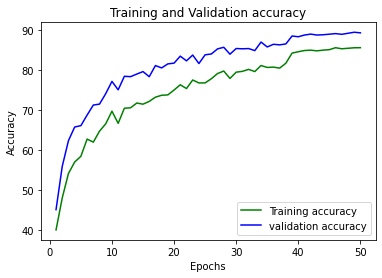

In [16]:
evaluate.plot_train_vs_test_accuracy(epochs, train_acc, test_acc)

GradCam on misclassified images

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

In [0]:
total_images = 25
gradcam_misclassified_images = evaluate.get_misclassified_images(model, device, testloader, classes, total_images)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

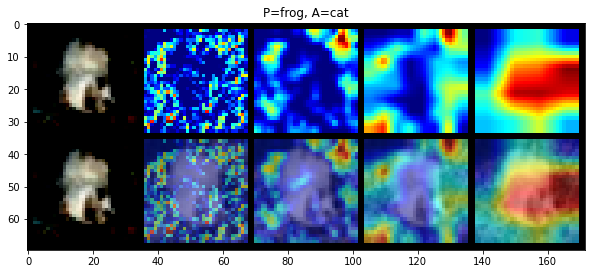

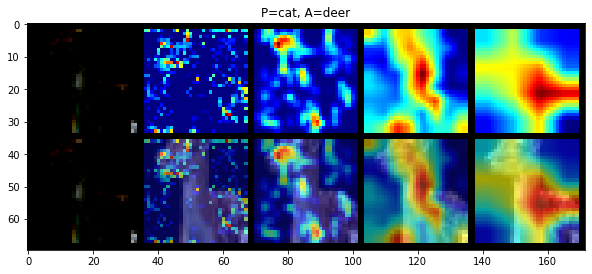

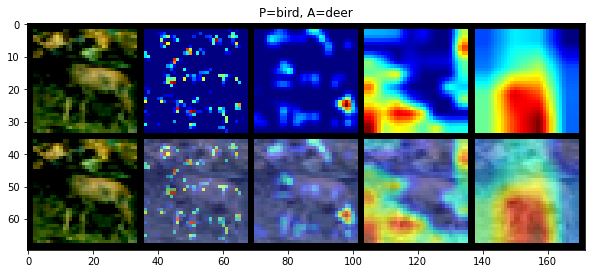

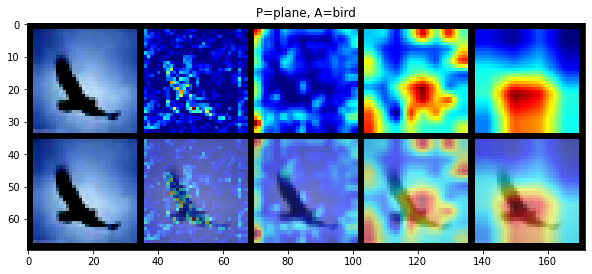

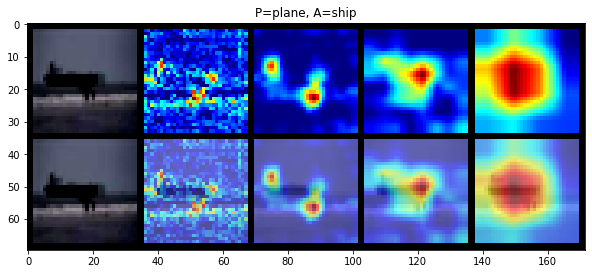

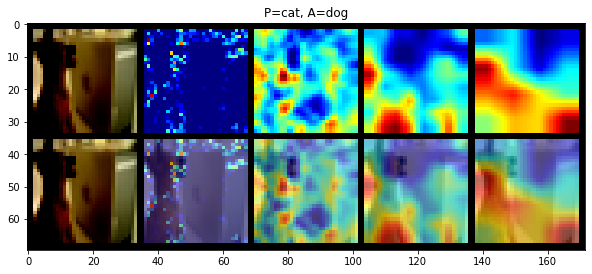

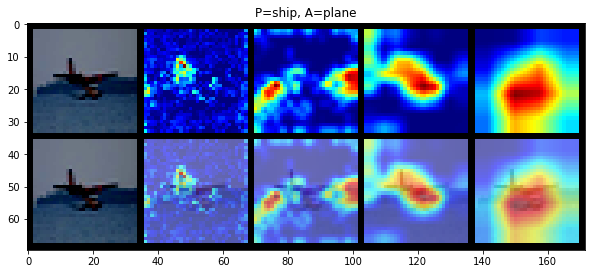

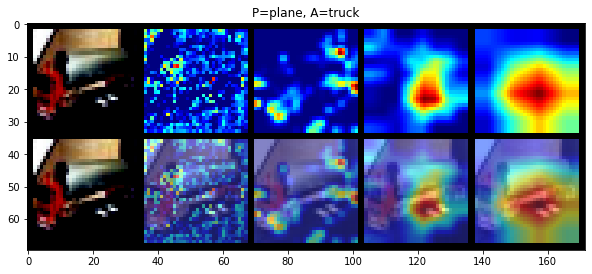

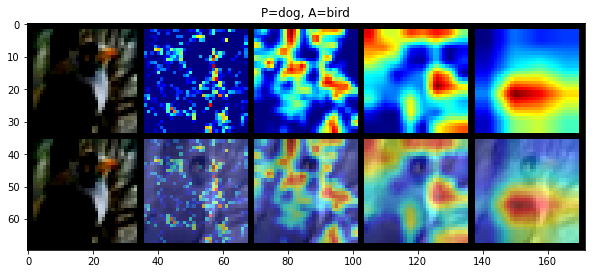

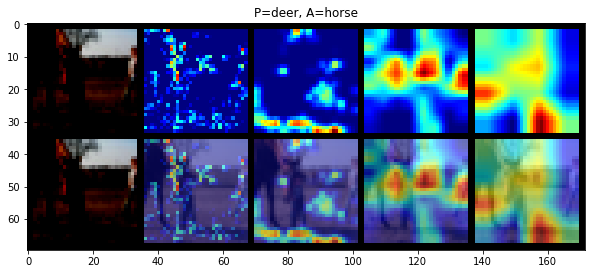

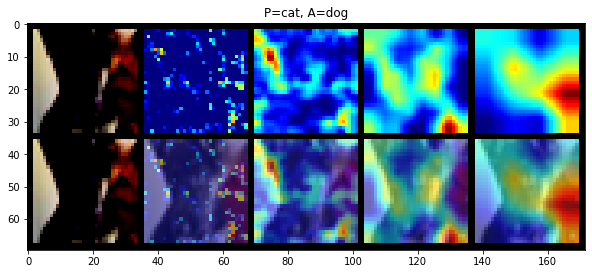

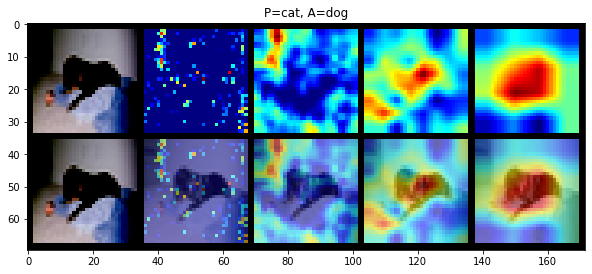

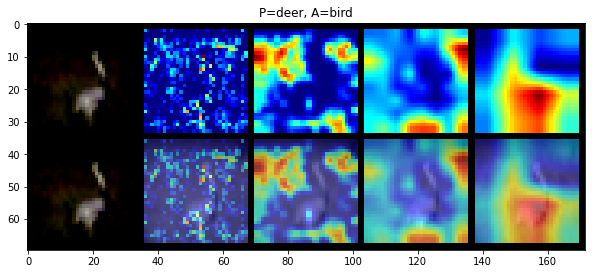

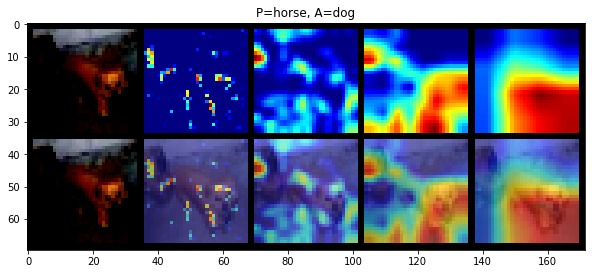

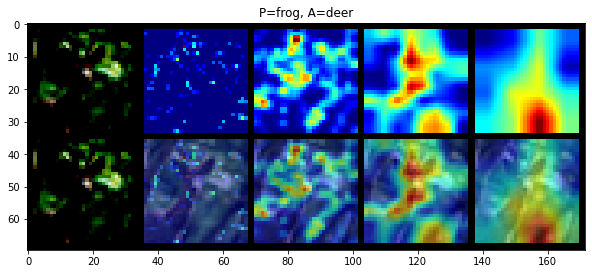

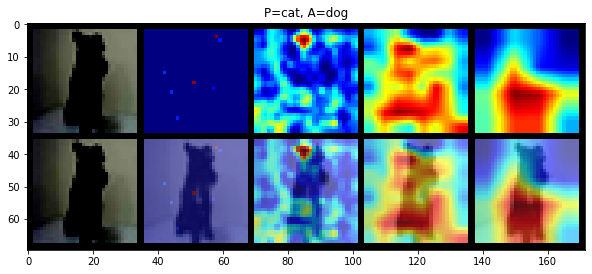

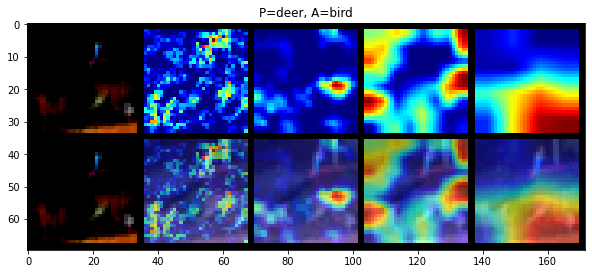

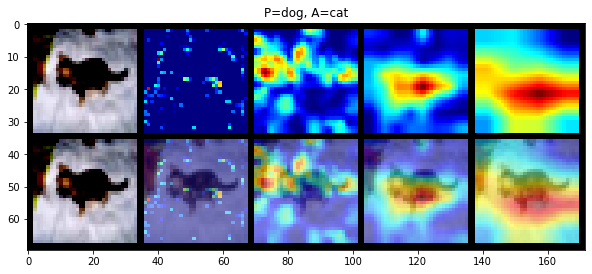

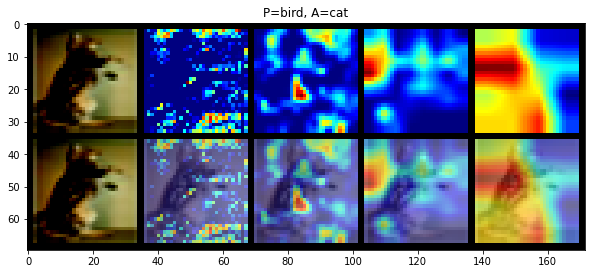

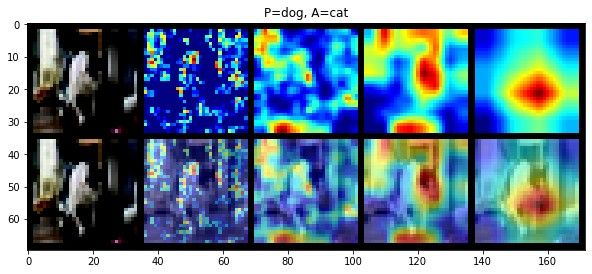

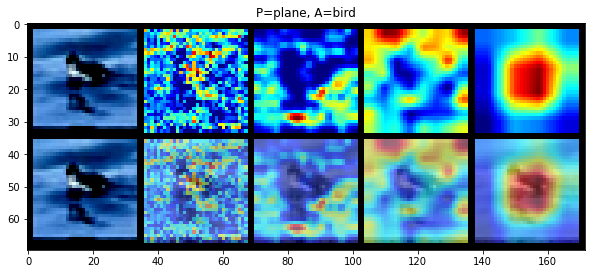

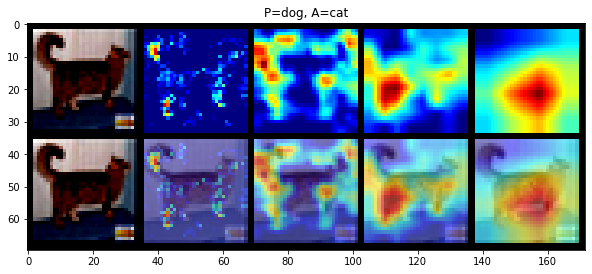

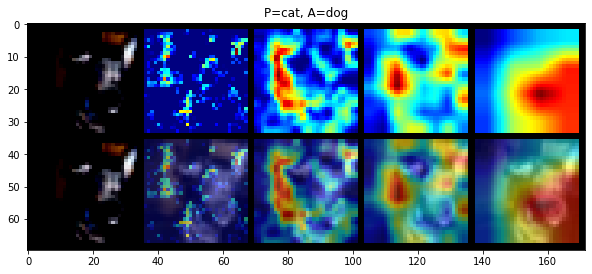

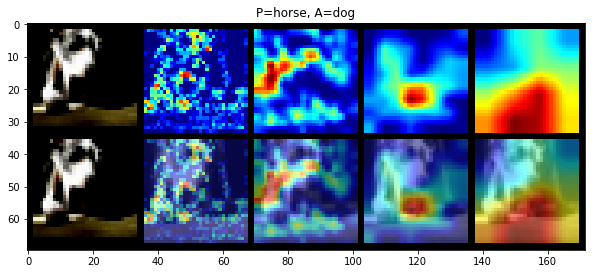

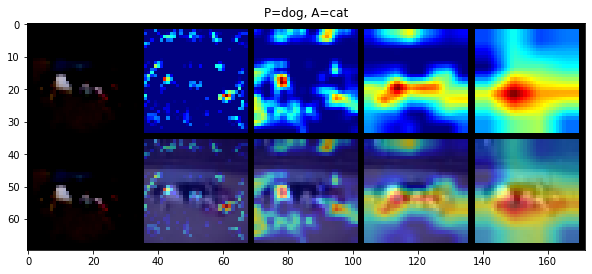

In [19]:
import copy
from torchvision.utils import make_grid, save_image
for i,k in enumerate(gradcam_misclassified_images):
  images1 = [gradcam_misclassified_images[i][0].cpu()]
  images2 =  [gradcam_misclassified_images[i][0].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(gradcam_misclassified_images[i][0].unsqueeze(0))
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    # mask, _= g(gradcam_misclassified_images[i][0].unsqueeze(0))
    # heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0])
    mask, _= g(gradcam_misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  # imshow(grid_image,c = classes[int(predicted)])
  imshow(grid_image,c = "P={}, A={}".format(str(classes[gradcam_misclassified_images[i][1].data.cpu().numpy()]),str(classes[gradcam_misclassified_images[i][2].data.cpu().numpy()])))